In [1]:
import pandas as pd

In [2]:
import pickle

In [53]:
import warnings

# 경고 메시지를 무시하도록 설정
warnings.filterwarnings("ignore")

In [4]:
with open('./pickles/check_count.pkl', "rb") as file:
    check_count = pickle.load(file)

with open('./pickles/news_data.pkl', "rb") as file:
    news_data = pickle.load(file)

with open('./pickles/stock_data.pkl', "rb") as file:
    stock_data = pickle.load(file)

- 긍정적인 효과를 알아보기 위해 전일비가 양값인 날을 추출해준다

In [5]:
# 전일비가 양값인 날짜 추출

stock_data = stock_data.query('date < "2024-01-01"')
stock_data = stock_data.query('re_trade_checkpoint == True or price_checkpoint == True')

In [6]:
stock_data = stock_data[stock_data['daily_change'].str.contains('\+')]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
temp_dict = {}
for index, row in check_count.iterrows():
    temp_dict[row['date']] = row['count']

In [9]:
count_list = []

for i in stock_data['date']:
    count_list.append(temp_dict.get(i,False))

In [10]:
stock_data['news_count'] = count_list

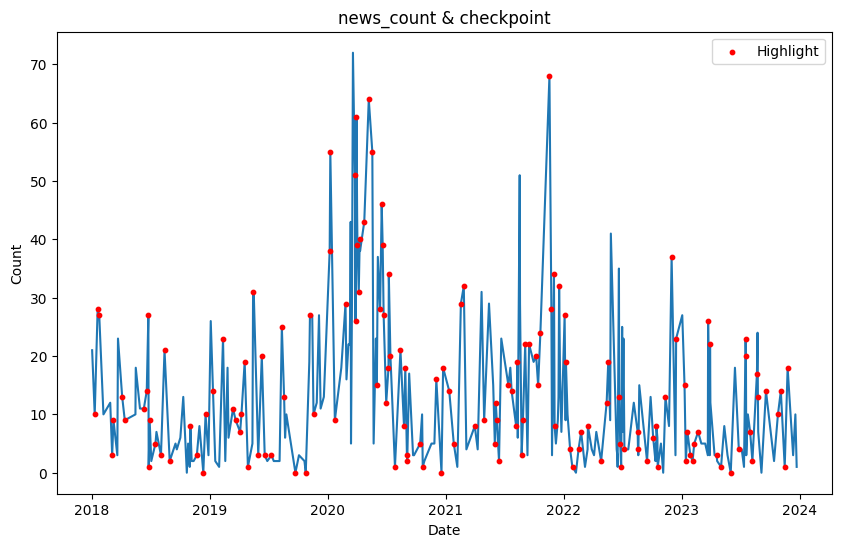

In [11]:
highlight_dates = stock_data['date']
highlight_counts = stock_data['news_count']

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 주가 라인 플롯
sns.lineplot(data=check_count, x='date', y='count')

# 특정 날짜에 점으로 표시
plt.scatter(x=highlight_dates, y=highlight_counts, color='red', label='Highlight', zorder=3, s=10)

plt.title('news_count & checkpoint')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()


- 뉴스의 갯수 5개를 기준으로 일자를 나눠서 lda분석 진행
    + 5개 이상 발행된 날에 상승한 것은 뉴스의 양(노출도)도 포함되어 상승했을 것으로 예상
    + 5개 미만 발행된 날에 상승한 것은 뉴스의 효과가 매우 높았다 라고 가정 -> 이 기사들의 토픽이 상승에 매우 좋은 요인일 것

In [12]:
stock_data = stock_data.reset_index()
stock_data = stock_data.drop(columns='index')

## 5개 미만 발행

In [13]:
# 이전 날짜와 당일 날짜의 뉴스 발행 5개 미만인 날짜 추출
five_news_date_index = stock_data.query('news_count < 5 & news_count != 0').index.tolist()

make_df = pd.DataFrame()

for i in five_news_date_index:
    if stock_data.iloc[i-1]['news_count'] < 5:
        make_df = pd.concat([make_df,stock_data.iloc[i:i+1,:]])

In [14]:
make_df

,_id,date,end_price,daily_change,start_price,high_price,low_price,trade,trade_checkpoint,price_checkpoint,re_trade_checkpoint,news_count
32,660cc16e6ca5177d63a420ba,2019-07-11,12150.0,+300,11900.0,12150.0,11900.0,27572.0,True,False,True,3
66,660cc12f6ca5177d63a41ef2,2020-09-03,21150.0,+750,20150.0,21400.0,19850.0,1040039.0,True,False,True,2
101,660cc0e06ca5177d63a41cc8,2022-01-28,20950.0,"+1,400",19650.0,20950.0,19500.0,389224.0,False,True,False,1
102,660cc0de6ca5177d63a41cb9,2022-02-15,20700.0,"+1,200",19500.0,22850.0,19250.0,4299151.0,True,True,True,4
111,660cc0c86ca5177d63a41c1c,2022-07-07,17250.0,+200,17200.0,17550.0,17100.0,53071.0,True,False,True,4
114,660cc0be6ca5177d63a41bd2,2022-09-15,15700.0,+100,15700.0,15750.0,15550.0,69790.0,True,False,True,2
125,660cc0a86ca5177d63a41b39,2023-02-03,14990.0,+80,14980.0,15120.0,14790.0,206263.0,True,False,True,2
131,660cc09b6ca5177d63a41ad9,2023-05-02,14300.0,+140,14170.0,14300.0,14060.0,69904.0,True,False,True,1
133,660cc0936ca5177d63a41aa0,2023-06-26,13120.0,+50,13010.0,13290.0,12910.0,63647.0,True,False,True,4


- 선별된 날짜에서 가장 많은 변화가 있었던 2020-09-03, 2022-01-28, 2022-02-15 3일의 뉴스들에 대한 LDA분석 진행

In [15]:
news_data['news_date'].describe()

count          17394
unique          1827
top       2018-07-26
freq             468
Name: news_date, dtype: object

In [16]:
# 'news_date' 열을 날짜 형식으로 변환
news_data['news_date'] = pd.to_datetime(news_data['news_date'])

# 해당 날짜의 데이터 필터링
filtered_data = news_data[(news_data['news_date'] == pd.to_datetime('2020-09-03')) |
                          (news_data['news_date'] == pd.to_datetime('2022-01-28')) |
                          (news_data['news_date'] == pd.to_datetime('2022-02-15'))]


In [17]:
filtered_data

,news_title,news_date,news_brand,news_contents,newText
9720,"'한글과컴퓨터' 52주 신고가 경신, 물 들어올 때 노 젓는 하반기 - 키움증권, ...",2020-09-03,한국경제,"◆ 최근 애널리스트 분석의견\n- 물 들어올 때 노 젓는 하반기 - 키움증권, BU...",한글과컴퓨터 주 신고가 경신 물 들어올 때 노 젓는 하반기 키움증권 ...
9721,"'한컴위드' 52주 신고가 경신, 최근 3일간 외국인 대량 순매도",2020-09-03,한국경제,◆ 주체별 매매동향\n- 최근 3일간 외국인 대량 순매도\n지난 한달을 기준으로 보...,한컴위드 주 신고가 경신 최근 일간 외국인 대량 순매도 주체별 매매동...
13805,2월 카카오뱅크·크래프톤 등 44개사 락업 풀려,2022-01-28,뉴시스,최근 1년간 월별 의무보유등록 해제 현황 *재판매 및 DB 금지\n\n[서울=뉴시스...,월 카카오뱅크 크래프톤 등 개사 락업 풀려 최근 년간 월별 의무보유등록 해제...
13852,"학생벤처 1세대 이한수 리탈코 대표 ""창업이 세상 바꿔..유니콘만 집중은 우려""",2022-02-15,지디넷코리아,"[인터뷰] 매출과 수익 구조 갖춰야..콜로세움, 골라라, 메디스태프 등에 투자 (지...",학생벤처 세대 이한수 리탈코 대표 창업이 세상 바꿔 유니콘만 집중은 우려 ...
13853,"[특징주] 한글과컴퓨터, 싸이월드 구글·애플에 심사 제출 소식에 상승세",2022-02-15,머니투데이,한글과컴퓨터가 싸이월드제트가 싸이월드 앱의 새 버전을 구글 플레이 스토어와 애플 앱...,특징주 한글과컴퓨터 싸이월드 구글 애플에 심사 제출 소식에 상승세 한글과컴퓨터...
13854,"추억의 싸이월드, '메타버스'로 돌아온다..관련주 들썩 (영상)",2022-02-15,파이낸셜뉴스,3D로 구현될 싸이월드 미니룸 구성화면. KBS 방송화면 캡처\n\n[파이낸셜뉴스]...,추억의 싸이월드 메타버스 로 돌아온다 관련주 들썩 영상 D로 구현될 싸이...
13855,싸이월드 메타버스로 돌아온다.. 관련주 들썩,2022-02-15,파이낸셜뉴스,싸이월드 앱 심사용 제출 소식\n브랜드 마케팅 플랫폼 성장 기대\n인트로메딕 주가 ...,싸이월드 메타버스로 돌아온다 관련주 들썩 싸이월드 앱 심사용 제출 소식 브랜드 ...


- LDA 머신러닝으로 돌리기에는 자료가 적어서 직관적 해석진행
    + 2020-09-03 : 52주 신고가 달성 기사만 있는 것으로 보아 테마주 or 마케팅이 아닌 다른 외부요인(실적 발표 등)이 작용한 것으로 판단
    + 2022-01-28 : 기사 내 한컴라이프케어(6개월 연장, 8월 예정) 즉, 락업이 연장되는 것이 주요 작용을 한것으로 예상
    + 2022-02-15 : 싸이월드에 관련된 기사가 많음, 해당 시기 메타버스 및 NFT의 주요 투자 시기였다는 것을 감안하면 메타버스 테마주로써 작용한 것으로 판단

## 5개 이상 발행

In [18]:
df_over_news_date = stock_data.query('news_count >= 5')

- 절대값으로 가장 많이 가격이 오른 날 10일을 선정

In [19]:
# daily_change가 string으로 이루어져 있으므로 이를 int로 변환

import re

def change_to_int(text):
    text = re.sub(r'\D', '', text)
    text = int(text)
    return text

In [20]:
df_over_news_date['daily_change'] = df_over_news_date['daily_change'].apply(change_to_int)

/tmp/ipykernel_6702/1738237333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_news_date['daily_change'] = df_over_news_date['daily_change'].apply(change_to_int)


In [21]:
df_over_news_date = df_over_news_date.sort_values('daily_change', ascending=False)

In [22]:
get_10_date = df_over_news_date.head(10)

In [23]:
get_10_date

,_id,date,end_price,daily_change,start_price,high_price,low_price,trade,trade_checkpoint,price_checkpoint,re_trade_checkpoint,news_count
93,660cc0ec6ca5177d63a41d19,2021-11-17,28400.0,60000,22400.0,28400.0,21850.0,8980888.0,True,True,True,68
80,660cc1056ca5177d63a41dca,2021-06-07,25450.0,4300,22200.0,26650.0,21800.0,10389887.0,True,True,False,9
95,660cc0ea6ca5177d63a41d09,2021-12-01,33150.0,4150,29950.0,33150.0,28400.0,6299287.0,False,True,False,34
48,660cc1456ca5177d63a41f92,2020-04-09,12600.0,2350,10500.0,13300.0,10400.0,6765253.0,True,True,False,40
129,660cc0a06ca5177d63a41afc,2023-03-29,17440.0,2130,15640.0,17950.0,15370.0,3475053.0,True,True,False,22
54,660cc13b6ca5177d63a41f4b,2020-06-16,14950.0,1850,13900.0,15100.0,13700.0,1776855.0,False,True,False,46
135,660cc08f6ca5177d63a41a84,2023-07-18,15030.0,1810,14870.0,16390.0,14590.0,10130885.0,True,True,False,20
63,660cc1316ca5177d63a41f00,2020-08-24,18300.0,1800,17100.0,19650.0,16900.0,4501939.0,True,True,True,8
85,660cc0fb6ca5177d63a41d81,2021-08-10,26900.0,1800,25650.0,27150.0,25250.0,2461945.0,True,True,False,19
97,660cc0e76ca5177d63a41cf4,2021-12-17,28900.0,1700,27300.0,31600.0,26200.0,9549898.0,True,True,True,32


In [24]:
# 날짜 추출
overdate_list = get_10_date['date']

In [25]:
overdate_list

93    2021-11-17
80    2021-06-07
95    2021-12-01
48    2020-04-09
129   2023-03-29
54    2020-06-16
135   2023-07-18
63    2020-08-24
85    2021-08-10
97    2021-12-17
Name: date, dtype: datetime64[ns]

In [26]:
# 해당 날짜의 데이터 df으로 통합 추출

df_concat = pd.DataFrame()

for i in overdate_list:
    df_concat = pd.concat([df_concat,news_data[(news_data['news_date'] == pd.to_datetime(i))]])

In [27]:
df_concat

,news_title,news_date,news_brand,news_contents,newText
13022,"삼성전자, 수험생 위한 '보따리' 푼다..""갤럭시 아카데미 시즌 1 실시""",2021-11-17,뉴스1,"(서울=뉴스1) 이창규 기자 = 삼성전자가 스마트폰, 태블릿, PC, 프린터 등 다...",삼성전자 수험생 위한 보따리 푼다 갤럭시 아카데미 시즌 실시 서울 ...
13023,"'흑역사' 대방출?..싸이월드, 내달 3D로 '재탄생' 예고",2021-11-17,더팩트,[더팩트｜이민주 기자] 토종 소셜미디어 싸이월드가 내달 서비스 중단 2년 2개월 만...,흑역사 대방출 싸이월드 내달 D로 재탄생 예고 이민주 토종 ...
13024,"한컴-싸이월드, '메타버스' 합작사 만들어 NFT 거래한다",2021-11-17,파이낸셜뉴스,"[파이낸셜뉴스] 싸이월드의 미니미가 메타버스 공간에서 물건을 구매하고, 배송까지 신...",한컴 싸이월드 메타버스 합작사 만들어 NFT 거래한다 싸이월드의 미니미가...
13025,"삼성 ""수험생·학생이라면 갤럭시 폰·노트북 할인 판매!""",2021-11-17,헤럴드경제,[헤럴드경제=박혜림 기자] 삼성전자가 수험생과 학생들을 위해 모바일·IT 기기 할인...,삼성 수험생 학생이라면 갤럭시 폰 노트북 할인 판매 박혜림 삼성전자가 ...
13026,"'갤버즈2' 패키지 할인..삼성전자, '갤럭시 아카데미'로 수험생 혜택 마련",2021-11-17,디지털타임스,"삼성전자는 18일부터 내년 3월 말까지 스마트폰, 태블릿, 노트 PC, 프린터 등 ...",갤버즈 패키지 할인 삼성전자 갤럭시 아카데미 로 수험생 혜택 마련 삼성전...
...,...,...,...,...,...
13465,"[특징주] NHN벅스, 메타버스 버전 '싸이월드 한컴다운' 개장에 강세",2021-12-17,머니S,이지운 기자 lee1019@mt.co.kr\n<저작권자 ⓒ '성공을 꿈꾸는 사람들의...,특징주 NHN벅스 메타버스 버전 싸이월드 한컴다운 개장에 강세 이지운 l...
13466,"""추억이 새록새록"".. 메타버스로 무장한 싸이월드, 오늘 재개장",2021-12-17,머니S,17일 IT 업계에 따르면 싸이월드제트는 SNS '싸이월드'와 메타버스 '싸이월드 ...,추억이 새록새록 메타버스로 무장한 싸이월드 오늘 재개장 일 IT 업계에...
13467,"'싸이월드 한컴타운', 오늘 오후 3시42분 '시범'서비스 시작",2021-12-17,뉴시스,"기사내용 요약\n'싸이월드' 구글·애플 앱, 심사 지연에 출시 또 연기\n메타버스 ...",싸이월드 한컴타운 오늘 오후 시 분 시범 서비스 시작 기사내용 요약 싸...
13468,"싸이월드, 미니홈피 재개 앞서 오후 3시42분 '싸이월드 한컴타운' 출시",2021-12-17,뉴스1,"(서울=뉴스1) 김근욱 기자,송화연 기자 = 싸이월드 운영사 싸이월드제트는 '미니홈...",싸이월드 미니홈피 재개 앞서 오후 시 분 싸이월드 한컴타운 출시 서울 뉴...


## 토큰,벡터 라이징

In [28]:
from konlpy.tag import Okt

In [29]:
stopword = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게','의','가','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [30]:
# Okt 형태소 분석기 인스턴스 생성
okt = Okt()

import re
import numpy as np


# 토크나이징 함수 정의
def tokenizer(raw, pos=["Noun","Alpha","Verb","Number"], stopword=stopword):

  get_list = []

  for word, tag in okt.pos(raw,norm=True,stem=True):
    if len(word) <= 1:
      word = '공란'

    if tag in pos and word not in stopword:
      get_list.append(word)
    else:
      get_list.append('공란')
    pass


  return get_list

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)

### 군집 최적화 구하기
- CoherenceModel 사용

In [32]:
pip install --upgrade scipy

  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
Note: you may need to restart the kernel to use updated packages.


In [33]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus

In [42]:
def Coherence_point(vectorizer,input_text_list):
  k_range = range(2,11)

  best_n = -1
  best_score = -1
  best_score_list = []
  preprocessed_texts = []
    

  for i in input_text_list:
      preprocessed_texts.append(tokenizer(i))
    

  for k in k_range:

      features = vectorizer.fit_transform(input_text_list)

      from sklearn.decomposition import LatentDirichletAllocation

      lda_model = LatentDirichletAllocation(n_components=k, random_state=42) #인스턴스화 #n_components 토픽의 갯수
      lda_model.fit(features) #교육

      # Gensim 사전 생성
      dictionary = Dictionary(preprocessed_texts)    

      # Gensim 코퍼스 생성
      corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


      # 상위 10개 단어를 추출, 비교
      topic_words = [[dictionary[id] for id in topic.argsort()[-10:]] for topic in lda_model.components_]


      # CoherenceModel 생성
      coherence_model = CoherenceModel(topics=topic_words, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')

      # 일관성 점수 계산
      coherence_score = coherence_model.get_coherence()
      
      
      # clusters = lda_model.transform(features).argmax(axis=1)  # 각 문서의 클러스터 할당

      
      # score = silhouette_score(features,clusters)

      print('k :',k,'score :',coherence_score)

      if coherence_score > best_score:
          best_n = k
          best_score = coherence_score

  print('best n :', best_n, 'best score :', best_score)
  print('---------------------------------------------')
  best_score_list.append(best_n)

  return best_score_list

In [43]:
best_score = []
counter = 0

for i in overdate_list:

  # 해당 날짜 추출
  processing_df = df_concat[(df_concat['news_date'] == i)]
    
  print(f'{i} 의 점수')
    
  # 토픽 추출
  # try:
  best_score.append(Coherence_point(vectorizer,processing_df['newText']))
  # except:
  #   best_score.append(f'오류 발생 : {counter}번재 날짜')
  #   print('-------------------------------------------')

  counter += 1

2021-11-17 00:00:00 의 점수
k : 2 score : 0.669403702912526
k : 3 score : 0.6307454369392625
k : 4 score : 0.6587172973397188
k : 5 score : 0.6457640399982407
k : 6 score : 0.610775548620696
k : 7 score : 0.6156495497079384
k : 8 score : 0.6008769934881787
k : 9 score : 0.6256021856407147
k : 10 score : 0.6477165142178972
best n : 2 best score : 0.669403702912526
---------------------------------------------
2021-06-07 00:00:00 의 점수
k : 2 score : 0.5523156821212543
k : 3 score : 0.6102344143556856
k : 4 score : 0.4999338401400756
k : 5 score : 0.45064839135982593
k : 6 score : 0.5227925089911225
k : 7 score : 0.5446201183892034
k : 8 score : 0.5825887290693809
k : 9 score : 0.5907166395488658
k : 10 score : 0.5989134591149329
best n : 3 best score : 0.6102344143556856
---------------------------------------------
2021-12-01 00:00:00 의 점수
k : 2 score : 0.6513140384068246
k : 3 score : 0.6255418382825505
k : 4 score : 0.5980540369243696
k : 5 score : 0.6435576220022146
k : 6 score : 0.63169

In [47]:
get_score = list()
for i in best_score:
    for j in i:
        get_score.append(j)

In [48]:
get_score

[2, 3, 2, 4, 2, 9, 3, 8, 4, 3]

- 10개 기사들에 대한 최적 군집수는 [2, 3, 2, 4, 2, 9, 3, 8, 4, 3]

## LDA 진행

In [49]:
# 추출 함수 제작

def LDAs(vectorizer,input_text_list,n_compo):

  features = vectorizer.fit_transform(input_text_list)

  # 단어 사전 추출
  dictionary_list = vectorizer.get_feature_names_out()

  # LDA 학습
  from sklearn.decomposition import LatentDirichletAllocation
  lda_model = LatentDirichletAllocation(n_components=n_compo, random_state=42) #인스턴스화 #n_components 토픽의 갯수
  lda_model.fit(features) #교육

  ## 상위 단어 추출
  ## 0 확률 1은 dictionary
  topics_list = list()
  for topic in lda_model.components_:
      df_datas = [topic, dictionary_list]
      df_topics = pd.DataFrame(data=df_datas)
      df_topics= df_topics.T
      df_topics = df_topics.sort_values(0, ascending=False)

      topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
      topics_list.append(topics_text)

  return topics_list

In [54]:
get_topics = []
counter = 0
for i in overdate_list:
    
  # 해당 날짜 추출
  processing_df = df_concat[(df_concat['news_date'] == i)]

  # 토픽 추출
  try:
    get_topics.append(LDAs(vectorizer,processing_df['newText'],get_score[counter]))
  except:
    get_topics.append(f'오류 발생 : {counter}번재 csv')

  counter += 1

In [59]:
# 뉴스 별 토픽 추출
total_counter = 0
for i in get_score:
  list_counter = 0
  for j in range(i):
    list_counter += 1
    print(f'{overdate_list.iloc[total_counter]}날짜 {list_counter}번째 토픽 : {get_topics[total_counter][j]}')

  total_counter += 1

  print('--------------------------------------')

2021-11-17 00:00:00날짜 1번째 토픽 : 공란 싸이월드 갤럭시 메타 한컴 버스 서비스 타운 되다 제트
2021-11-17 00:00:00날짜 2번째 토픽 : 싸이월드 메타 공란 타운 한컴 버스 플랫폼 제트 서비스 nft
--------------------------------------
2021-06-07 00:00:00날짜 1번째 토픽 : 디지털 서비스 매도 종목 한글과컴퓨터 거래 셀트리온 코스닥 투자자 외국인
2021-06-07 00:00:00날짜 2번째 토픽 : 공란 서비스 매도 소프트웨어 한컴 종목 saas 한글과컴퓨터 억원 아로와나
2021-06-07 00:00:00날짜 3번째 토픽 : 디지털 서비스 매도 종목 한글과컴퓨터 거래 셀트리온 코스닥 투자자 외국인
--------------------------------------
2021-12-01 00:00:00날짜 1번째 토픽 : 공란 소프트 웨이브 sw 소프트웨어 서울 뉴스 강남구 코엑스 디지털
2021-12-01 00:00:00날짜 2번째 토픽 : 공란 싸이월드 타운 제트 개발 한컴 메타 연동 버스 되다
--------------------------------------
2020-04-09 00:00:00날짜 1번째 토픽 : 공란 파이오링크 상승 한글과컴퓨터 데이타 가다 기관 외국인 나무 에스
2020-04-09 00:00:00날짜 2번째 토픽 : 공란 os mds 상승 시스템 유비 록스 기관 한컴 테크
2020-04-09 00:00:00날짜 3번째 토픽 : 자료 금액 정치 추출 개사 어비스 사들이다 증권사 외국 수치
2020-04-09 00:00:00날짜 4번째 토픽 : 자료 금액 정치 추출 개사 어비스 사들이다 증권사 외국 수치
--------------------------------------
2023-03-29 00:00:00날짜 1번째 토픽 : 네이버 공란 ai 한컴오피스 클라우드 크다 하이퍼 적용 한컴 양사
2023-03-29 00:00:00날짜 2번째 토픽 : 공란

In [58]:
overdate_list

93    2021-11-17
80    2021-06-07
95    2021-12-01
48    2020-04-09
129   2023-03-29
54    2020-06-16
135   2023-07-18
63    2020-08-24
85    2021-08-10
97    2021-12-17
Name: date, dtype: datetime64[ns]

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
get_10_date

,_id,date,end_price,daily_change,start_price,high_price,low_price,trade,trade_checkpoint,price_checkpoint,re_trade_checkpoint,news_count
93,660cc0ec6ca5177d63a41d19,2021-11-17,28400.0,60000,22400.0,28400.0,21850.0,8980888.0,True,True,True,68
80,660cc1056ca5177d63a41dca,2021-06-07,25450.0,4300,22200.0,26650.0,21800.0,10389887.0,True,True,False,9
95,660cc0ea6ca5177d63a41d09,2021-12-01,33150.0,4150,29950.0,33150.0,28400.0,6299287.0,False,True,False,34
48,660cc1456ca5177d63a41f92,2020-04-09,12600.0,2350,10500.0,13300.0,10400.0,6765253.0,True,True,False,40
129,660cc0a06ca5177d63a41afc,2023-03-29,17440.0,2130,15640.0,17950.0,15370.0,3475053.0,True,True,False,22
54,660cc13b6ca5177d63a41f4b,2020-06-16,14950.0,1850,13900.0,15100.0,13700.0,1776855.0,False,True,False,46
135,660cc08f6ca5177d63a41a84,2023-07-18,15030.0,1810,14870.0,16390.0,14590.0,10130885.0,True,True,False,20
63,660cc1316ca5177d63a41f00,2020-08-24,18300.0,1800,17100.0,19650.0,16900.0,4501939.0,True,True,True,8
85,660cc0fb6ca5177d63a41d81,2021-08-10,26900.0,1800,25650.0,27150.0,25250.0,2461945.0,True,True,False,19
97,660cc0e76ca5177d63a41cf4,2021-12-17,28900.0,1700,27300.0,31600.0,26200.0,9549898.0,True,True,True,32


In [63]:
plot_df = get_10_date.sort_values('date')

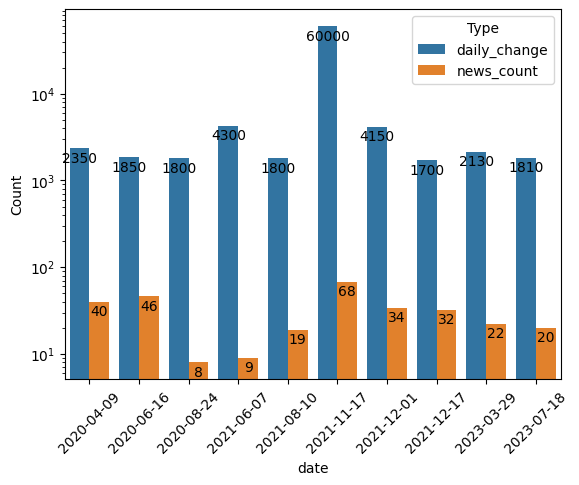

In [88]:
# 그래프 그리기
ax = sns.barplot(x='date', y='Count', hue='Type', data=plot_df_long)

# 각 막대 위에 값을 표시하기
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, -7), 
                textcoords='offset points')

plt.yscale('log')
plt.xticks(rotation=45)
plt.show()



In [93]:
df_concat.query('news_date == "2023-07-18"')

,news_title,news_date,news_brand,news_contents,newText
16505,"[데이터로 보는 증시]대주전자재료·에코프로비엠, 기관·외국인 코스닥 순매수 1위(7...",2023-07-18,서울경제,"셀트리온헬스케어, 개인 순매수 1위 [서울경제]\n18일 코스닥 지수가 2% 가까이...",데이터로 보는 증시 대주전자재료 에코프로비엠 기관 외국인 코스닥 순매수 위 ...
16506,"""물적분할에 주가 떨어질라""…자사주 소각 내건 한컴 주가 급등",2023-07-18,한국경제,사진=연합뉴스\n\n한글과컴퓨터가 18년만에 자사주 소각을 결정하면서 주가가 13%...,물적분할에 주가 떨어질라 자사주 소각 내건 한컴 주가 급등 사진 한글과컴퓨터...
16507,"지란지교소프트, 산업은행에 '나모 크로스에디터4' 공급",2023-07-18,전자신문,지란지교소프트 '나모 크로스에디터4'.(지란지교소프트 제공)\n지란지교소프트가 한국...,지란지교소프트 산업은행에 나모 크로스에디터 공급 지란지교소프트 나모 크로스...
16508,"[특징주] 한글과컴퓨터, 물적분할·자사주 소각 결정에 강세",2023-07-18,머니투데이,한글과컴퓨터가 웹오피스 사업 부문을 물적분할 한다는 소식에 강세다.\n18일 한국거...,특징주 한글과컴퓨터 물적분할 자사주 소각 결정에 강세 한글과컴퓨터가 웹오피스 ...
16509,"지란지교소프트, 한국산업은행에 `나모 크로스에디터4` 공급",2023-07-18,디지털타임스,지란지교소프트는 한국산업은행에 자사 웹에디터 '나모 크로스에디터4'를 공급한다고 1...,지란지교소프트 한국산업은행에 나모 크로스에디터 공급 지란지교소프트는 한국산업...
16510,"한글과컴퓨터, 웹오피스 사업부문 물적분할 결정에 17% 강세",2023-07-18,매일경제,한글과컴퓨터 사옥 전경. [사진 출처 = 한글과컴퓨터]\n한글과컴퓨터가 기존 웹오피...,한글과컴퓨터 웹오피스 사업부문 물적분할 결정에 강세 한글과컴퓨터 사옥 전경...
16511,"한글과컴퓨터, 웹오피스 사업부문 물적분할 소식에 강세",2023-07-18,매일경제,한글과컴퓨터가 주력 사업인 웹오피스 사업부문을 물적분할하고 자사주를 소각한다는 소식...,한글과컴퓨터 웹오피스 사업부문 물적분할 소식에 강세 한글과컴퓨터가 주력 사업인 웹...
16512,"한글과컴퓨터, 웹오피스 사업부문 물적분할 소식에 주가↑",2023-07-18,한국경제,한글과컴퓨터가 주력 사업인 웹오피스 사업부문을 물적분할한다는 소식에 주가가 급등하고...,한글과컴퓨터 웹오피스 사업부문 물적분할 소식에 주가 한글과컴퓨터가 주력 사업인 ...
16513,"[특징주]한글과컴퓨터, '한컴AI웹에디터' 분할 신설에 17% 급등",2023-07-18,서울경제,한글과컴퓨터 CI/ 사진제공=한글과컴퓨터\n[서울경제]\n한글과컴퓨터(030520)...,특징주 한글과컴퓨터 한컴AI웹에디터 분할 신설에 급등 한글과컴퓨터 C...
16514,"[ET라씨로] 한글과컴퓨터, 회사분할 소식에 주가 급등",2023-07-18,전자신문,ET라씨로는 인공지능(AI) 기반으로 선별·분석한 주식 정보와 종목 매매 신호를 제...,ET라씨로 한글과컴퓨터 회사분할 소식에 주가 급등 ET라씨로는 인공지능 AI ...


In [99]:
4300+1800+60000+4150+1700+2130

74080